# Import Libraries

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as k

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)


# Verify TensorFlow version and Keras version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.12.0


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.12.0


# Mount Google Drive to Colab environment

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Research Assignment Reporting Functions

In [6]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

# Loading MNIST Dataset


In [7]:
(train_val_images, train_val_labels), (X_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


# Split train dataset into train and validation data

In [8]:
X_train, X_val, y_train, y_val = train_test_split(train_val_images, train_val_labels, test_size=5000, random_state=42)

# Explore Shape of Data

In [9]:
print('X_train:\t{}'.format(X_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('X_val:\t\t{}'.format(X_val.shape))
print('y_val:\t\t{}'.format(y_val.shape))
print('X_test:\t\t{}'.format(X_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

X_train:	(55000, 28, 28)
y_train:	(55000,)
X_val:		(5000, 28, 28)
y_val:		(5000,)
X_test:		(10000, 28, 28)
y_test:		(10000,)


# EDA

In [10]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [7 2 2 4 1 4 0 4 9 1]



<Axes: xlabel='Class', ylabel='Count'>

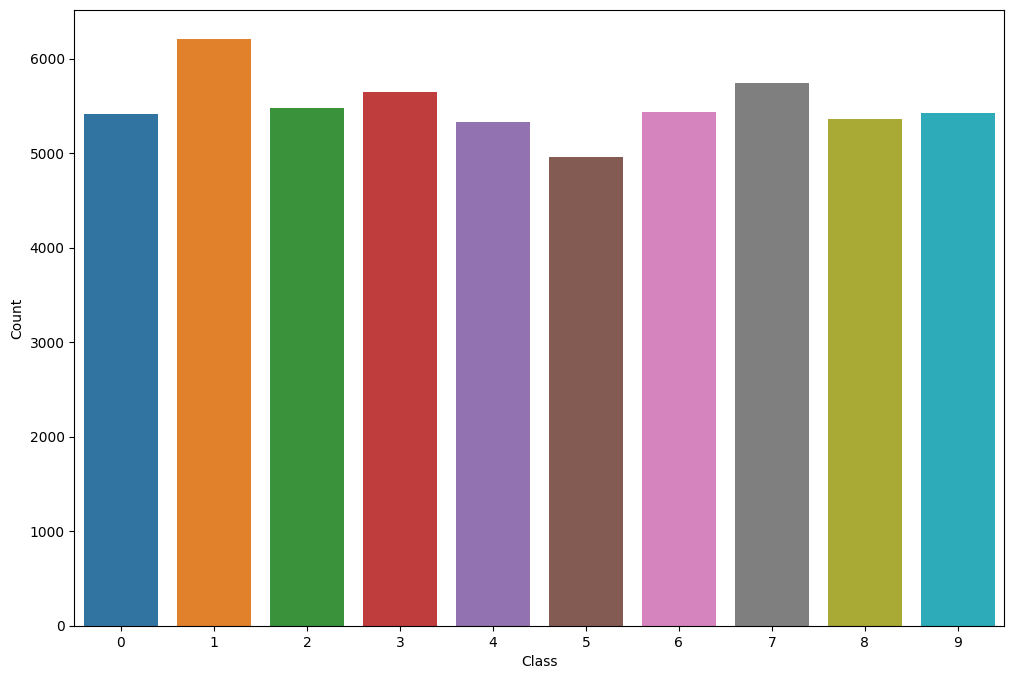

In [11]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(y_train).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count)

In [12]:
Counter(y_train).most_common()

[(1, 6207),
 (7, 5745),
 (3, 5648),
 (2, 5481),
 (6, 5432),
 (9, 5420),
 (0, 5414),
 (8, 5365),
 (4, 5329),
 (5, 4959)]

In [13]:
Counter(y_val).most_common()

[(1, 535),
 (9, 529),
 (7, 520),
 (4, 513),
 (0, 509),
 (8, 486),
 (6, 486),
 (3, 483),
 (2, 477),
 (5, 462)]

In [14]:
Counter(y_test).most_common()

[(1, 1135),
 (2, 1032),
 (7, 1028),
 (3, 1010),
 (9, 1009),
 (4, 982),
 (0, 980),
 (8, 974),
 (6, 958),
 (5, 892)]

# Plot sample images with their labels

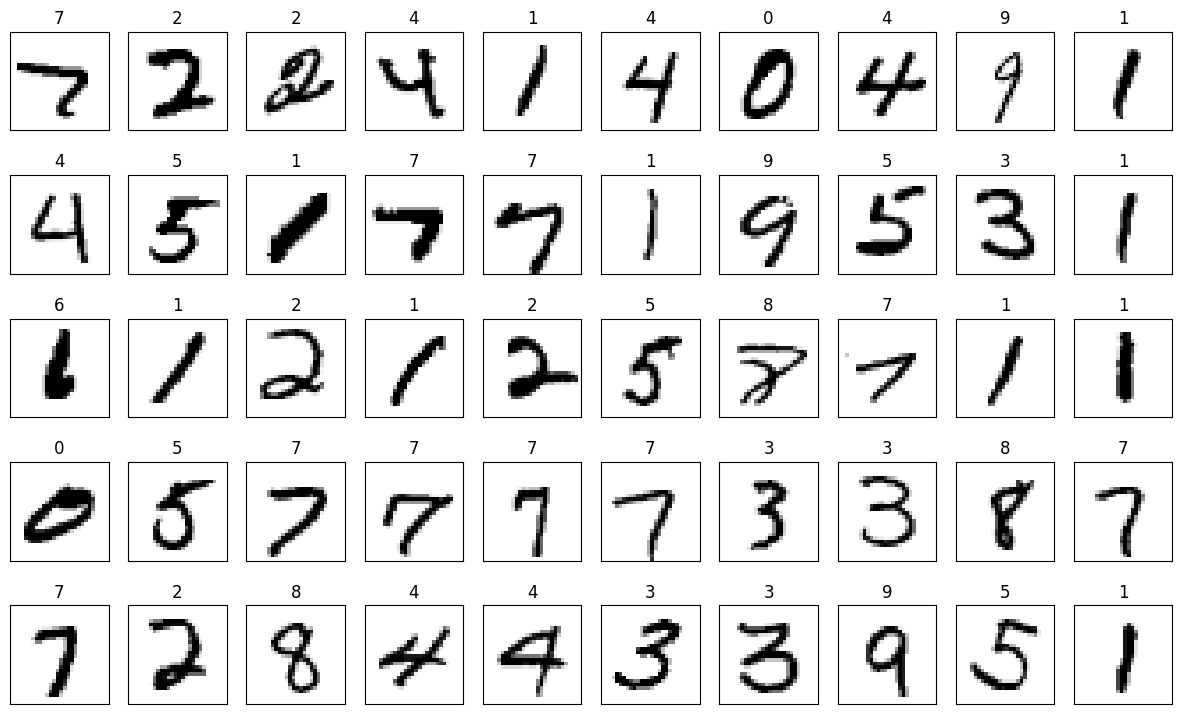

In [15]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i].reshape(28,28), cmap='binary')




# Preprocessing Data

* Before we build our model, we need to prepare the data into the shape the network expected
* More specifically, we will convert the labels (integers 0 to 9) to 1D numpy arrays of shape (10,) with elements 0s and 1s.
* We also reshape the images from 2D arrays of shape (28,28) to 1D float32 arrays of shape (784,) and then rescale their elements to values between 0 and 1.

## Apply one-hot encoding on the labels
We will change the way the labels are represented from numbers (0 to 9) to vectors (1D arrays) of shape (10, ) with all the elements set to 0 except the one which the label belongs to - which will be set to 1. For example:

| original label | one-hot encoded label|
---------------- | ----------------------
5	| [0 0 0 0 0 1 0 0 0 0]
7	| [0 0 0 0 0 0 0 1 0 0]
1	| [0 1 0 0 0 0 0 0 0 0]

In [16]:
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))

First ten entries of y_train:
 [7 2 2 4 1 4 0 4 9 1]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [17]:
print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_val_encoded shape: ', y_val_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

y_train_encoded shape:  (55000, 10)
y_val_encoded shape:  (5000, 10)
y_test_encoded shape:  (10000, 10)


# Reshape the images to 1D arrays
Reshape the images from shape (28, 28) 2D arrays to shape (784, ) vectors (1D arrays).

In [18]:
# Before reshape:
print('X_train:\t{}'.format(X_train.shape))
print('X_val:\t\t{}'.format(X_val.shape))
print('X_test:\t\t{}'.format(X_test.shape))

X_train:	(55000, 28, 28)
X_val:		(5000, 28, 28)
X_test:		(10000, 28, 28)


In [19]:
np.set_printoptions(linewidth=np.inf)
print("{}".format(X_train[2000]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  17   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  86 171 210 160  20  38  54  34   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  10  72 159 242 253 253 253 213 234 253 229 189  74  3

In [20]:
# Reshape the images:
X_train_reshaped = np.reshape(X_train, (55000, 784))
X_val_reshaped = np.reshape(X_val, (5000, 784))
X_test_reshaped = np.reshape(X_test, (10000, 784))

# After reshape:
print('X_train_reshaped shape: ', X_train_reshaped.shape)
print('X_val_reshaped shape: ', X_val_reshaped.shape)
print('X_test_reshaped shape: ', X_test_reshaped.shape)

X_train_reshaped shape:  (55000, 784)
X_val_reshaped shape:  (5000, 784)
X_test_reshaped shape:  (10000, 784)


# Rescale Pixel Values

1. Each element in an image is a pixel value
2. Pixel values range from 0 to 255
3. 0 = White
4. 255 = Black

In [21]:
print(set(X_train_reshaped[0]))

{0, 8, 139, 11, 13, 144, 20, 149, 25, 27, 30, 32, 162, 38, 43, 48, 176, 181, 55, 56, 183, 58, 59, 60, 61, 191, 193, 196, 80, 214, 87, 218, 247, 120, 93, 220, 96, 99, 228, 230, 231, 232, 105, 102, 235, 236, 237, 110, 112, 241, 243, 115, 118, 119, 248, 249, 250, 251, 253, 254}


In [22]:
X_train_norm = X_train_reshaped.astype('float32') / 255
X_val_norm = X_val_reshaped.astype('float32') / 255
X_test_norm = X_test_reshaped.astype('float32') / 255

In [23]:
# Take a look at the first reshaped and normalized training image:
print(set(X_train_norm[0]))

{0.0, 0.9529412, 0.4392157, 0.94509804, 0.7490196, 0.3137255, 0.99607843, 0.99215686, 0.972549, 0.92156863, 0.5647059, 0.4117647, 0.1882353, 0.09803922, 0.3647059, 0.58431375, 0.9098039, 0.8392157, 0.4509804, 0.23137255, 0.90588236, 0.98039216, 0.34117648, 0.21568628, 0.23921569, 0.22745098, 0.3882353, 0.9254902, 0.76862746, 0.050980393, 0.1254902, 0.54509807, 0.63529414, 0.70980394, 0.03137255, 0.14901961, 0.4, 0.9843137, 0.8627451, 0.9019608, 0.9764706, 0.75686276, 0.6901961, 0.96862745, 0.89411765, 0.7176471, 0.85490197, 0.043137256, 0.92941177, 0.43137255, 0.3764706, 0.11764706, 0.105882354, 0.078431375, 0.23529412, 0.21960784, 0.16862746, 0.4627451, 0.46666667, 0.47058824}


# Build Model

In [24]:
nodes = 2048
model = Sequential()
model.add(Dense(input_shape=[784,], units=nodes, activation=tf.nn.relu))
model.add(Dropout(0.5))
model.add(Dense(name="output_layer", units=10, activation=tf.nn.softmax))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              1607680   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 1,628,170
Trainable params: 1,628,170
Non-trainable params: 0
_________________________________________________________________


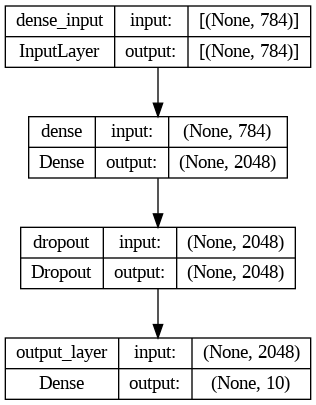

In [26]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True)

In [27]:
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [28]:
history = model.fit(X_train_norm, y_train_encoded,
          validation_data=(X_val_norm, y_val_encoded),
          epochs=200,
          callbacks=[tf.keras.callbacks.ModelCheckpoint("/content/drive/DNN_model_03t.h5",save_best_only=True, save_weights_only=False),
                     tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)]
    )

Epoch 1/200
1719/1719 [==============================] - 11s 3ms/step - loss: 0.2527 - accuracy: 0.9262 - val_loss: 0.1356 - val_accuracy: 0.9554
Epoch 2/200
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1357 - accuracy: 0.9614 - val_loss: 0.1005 - val_accuracy: 0.9734
Epoch 3/200
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1132 - accuracy: 0.9694 - val_loss: 0.0880 - val_accuracy: 0.9762
Epoch 4/200
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0926 - accuracy: 0.9749 - val_loss: 0.0926 - val_accuracy: 0.9766
Epoch 5/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0863 - accuracy: 0.9773 - val_loss: 0.0896 - val_accuracy: 0.9796
Epoch 6/200
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0744 - accuracy: 0.9807 - val_loss: 0.0853 - val_accuracy: 0.9814
Epoch 7/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0678 - accuracy: 0.9823 - val_loss: 0.0778 - val_a

# Evaluate the model

In [29]:
model = tf.keras.models.load_model("/content/drive/DNN_model_03t.h5")
print(f"Test acc: {model.evaluate(X_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0722 - accuracy: 0.9835
Test acc: 0.984


In [30]:
loss, accuracy = model.evaluate(X_test_norm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 2ms/step - loss: 0.0722 - accuracy: 0.9835
test set accuracy:  98.35000038146973


# Making Predictions

In [31]:
preds = model.predict(X_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 1ms/step
shape of preds:  (10000, 10)


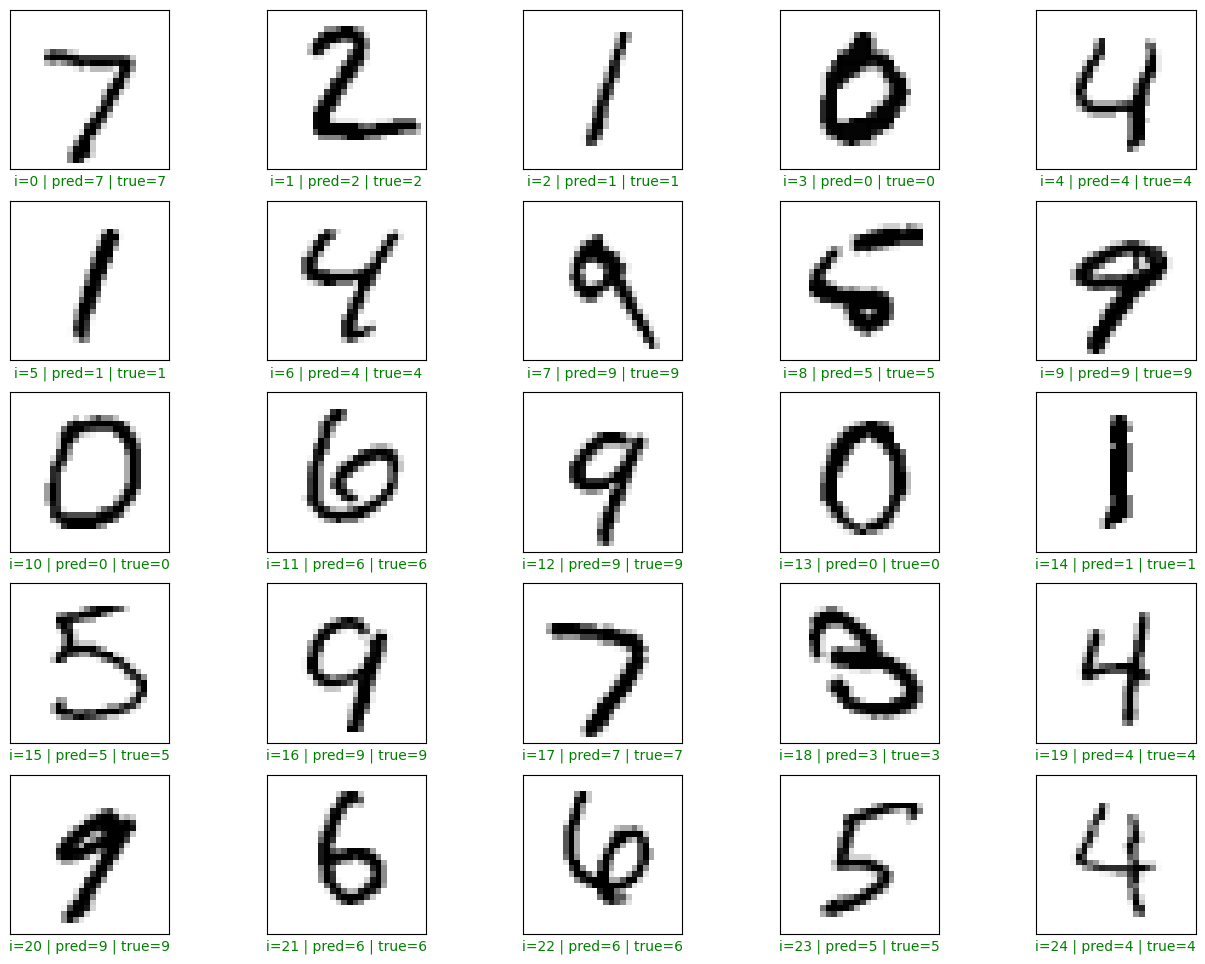

In [32]:
plt.figure(figsize = (16, 12))

start_index = 0

# plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(X_test[start_index + i], cmap='binary')
plt.show()

# Reviewing Performance

In [33]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [35]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
31,0.014,0.996,0.099,0.983
32,0.012,0.997,0.094,0.985
33,0.010,0.997,0.094,0.987
34,0.009,0.997,0.095,0.984
35,0.008,0.997,0.095,0.985


<ipython-input-36-8a5a046bfb84>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


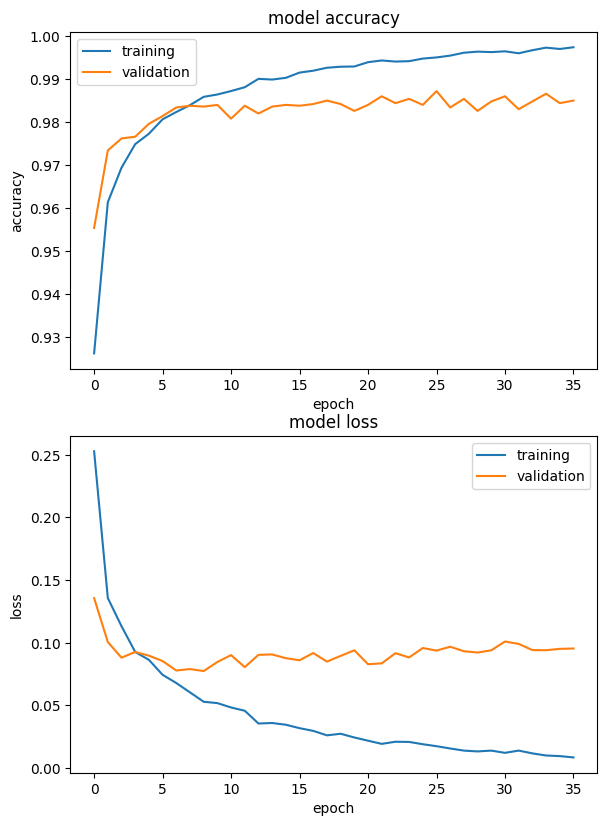

In [36]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(6,8))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [37]:
pred1= model.predict(X_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 2ms/step


In [38]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Accuracy Score: 0.9835
Root Mean Square Error: 0.5558776843874919


# Create the confusion matrix

In [39]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(X_test_norm), axis=-1)
pred_classes;

313/313 [==============================] - 1s 2ms/step


In [40]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [41]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9
0,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%,0.00%
1,0.00%,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
2,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
3,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
4,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%
5,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
6,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%
7,0.00%,0.00%,0.00%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,99.99%
8,0.00%,0.00%,0.00%,0.00%,0.00%,99.34%,0.66%,0.00%,0.00%,0.00%
9,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,100.00%


# Visualize Confusion Matrix

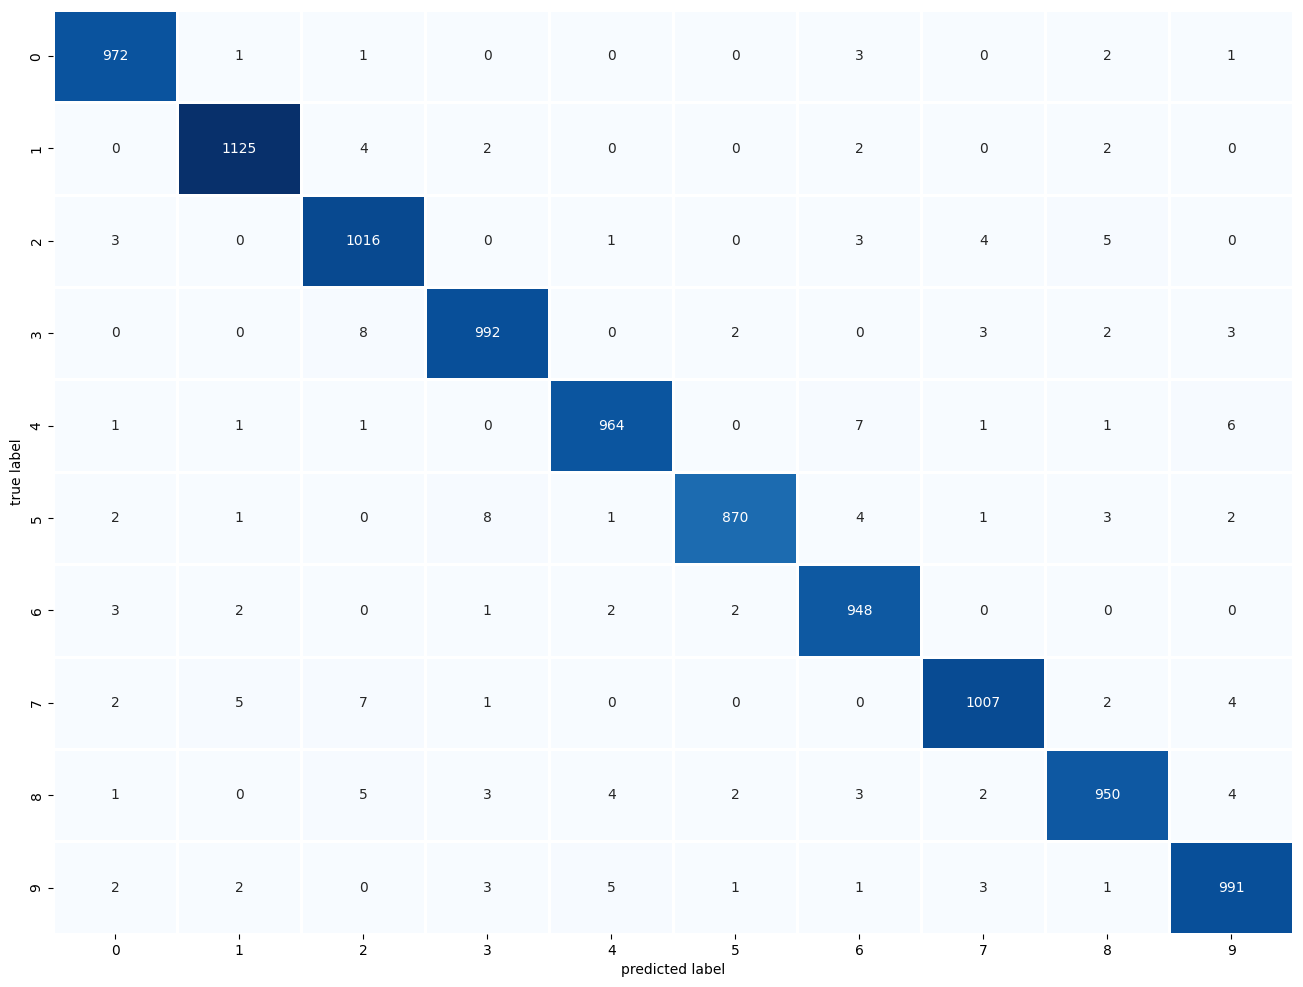

In [42]:
plot_confusion_matrix(y_test, pred_classes)

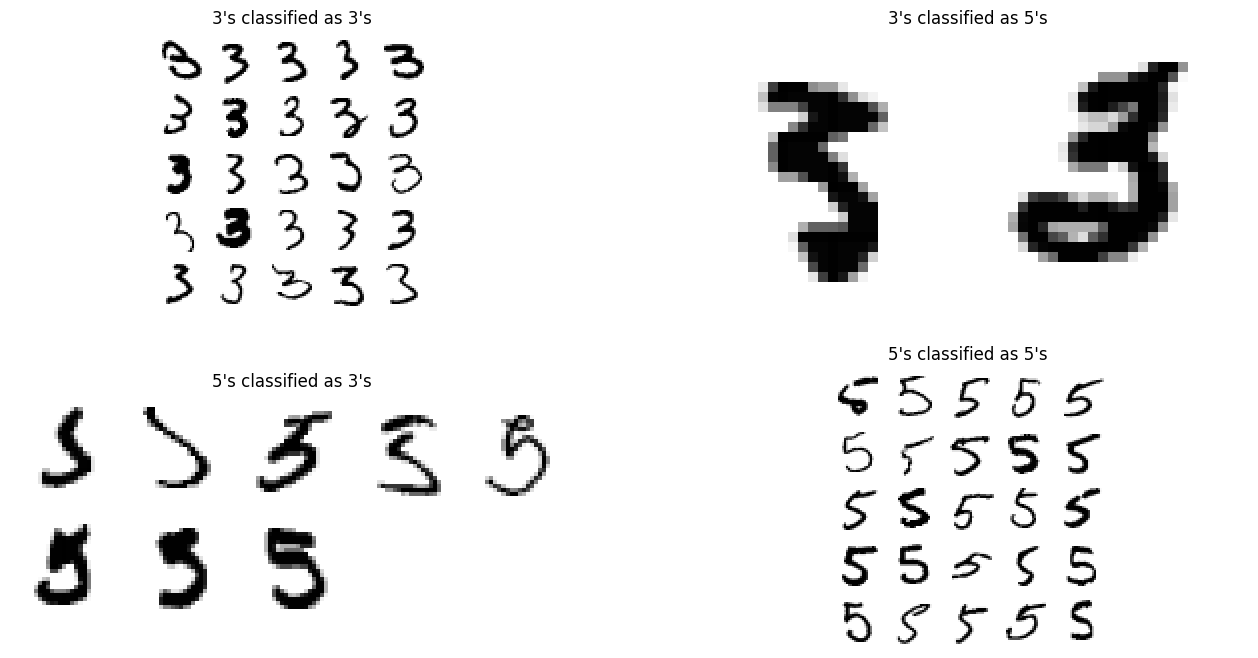

In [43]:
cl_a, cl_b = 3,5
X_aa = X_test_norm[(y_test == cl_a) & (pred_classes == cl_a)]
X_ab = X_test_norm[(y_test == cl_a) & (pred_classes == cl_b)]
X_ba = X_test_norm[(y_test == cl_b) & (pred_classes == cl_a)]
X_bb = X_test_norm[(y_test == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(16,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

# Get Activation Values of the Hidden Nodes (128)

In [44]:
# Extracts the outputs of the layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 3 layers


In [45]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(np.concatenate((X_train_norm, X_val_norm), axis=0))
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the nodes has one activation value per training image

1875/1875 [==============================] - 3s 2ms/step


(60000, 2048)

In [46]:
output_layer_activations.shape

(60000, 2048)

In [47]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 9.927589416503906


In [48]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (60000, 2048)
The output for the first image are [0.    0.    1.188 ... 0.    0.    0.   ]
The sum of the probabilities is (approximately) 374.9857482910156


# Create a dataframe with the activation values and the class labels

In [49]:
#Get the dataframe of all the node values
activation_data = {'actual_class':np.concatenate((y_train, y_val), axis=0)}
for k in range(nodes):
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,7.000,2.0,2.0,4.00,1.000,4.000,0.000,4.000,9.000,1.000,4.000,5.000,1.000,7.000,7.000
act_val_0,0.000,0.0,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.228,0.000,0.000,0.000,0.000
act_val_1,0.000,0.0,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.590,0.000,0.000
act_val_2,1.188,0.0,0.0,0.00,0.000,0.984,0.000,0.000,0.000,0.000,0.239,0.000,0.000,0.737,1.274
act_val_3,0.000,0.0,0.0,0.06,0.000,0.016,0.000,0.338,0.000,0.000,0.000,1.170,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
act_val_2043,0.000,0.0,0.0,0.00,0.429,0.000,0.126,0.000,0.188,0.455,0.000,1.071,0.079,0.000,0.000
act_val_2044,0.415,0.0,0.0,0.00,0.000,0.000,0.596,0.000,0.000,0.000,0.419,0.357,0.000,0.308,3.258
act_val_2045,0.000,0.0,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
act_val_2046,0.000,0.0,0.0,0.00,0.000,1.505,0.000,2.345,0.611,0.000,1.574,0.000,0.000,0.000,0.000
